In [1]:
import sys
from pathlib import Path

from farm import __file__ as farm_init_path
farm_dir = Path(farm_init_path).parent

# Leads to isinstance errors when ~/pylib/farm is in $PYTHONPATH
if str(farm_dir) in sys.path:
      sys.path.remove(str(farm_dir))

%matplotlib inline

# Data-creation pipeline overview
For running any pipelines with `farm`, an `farm.observing.Observation` instance forms the main workhorse. In order to perform this role, it contains all information related to the:
- Observational field (e.g. pointing centre)
- Frequency setup (e.g. observing band definitions)
- Calibration tables (e.g. complex gains)
- Sky model
- Execution of the 'actual' observation (e.g. scan times)

To instantiate an observation, three arguments are required:
1. `field`: A `farm.observing.Field` instance
2. `telescope`: A `farm.observing.Telescope` instance
3. `correlator`: A `farm.observing.Correlator` instance

## Setting up the observational Field
In order to instantiate a `farm.observing.Field` instance, the following positional arguments are required:
1. `ra0` (`str`): Right ascension of pointing centre \[HH:MM:SS.S\]
2. `dec0` (`str`): Declination of pointing centre \[DD:MM:SS.S\]
3. `frame` (`str`): Coordinate frame passed to `astropy.coordinate.SkyCoord` e.g. `fk5`
4. `nx` (`int`): Number of pixels in right ascension
5. `ny` (`int`): Number of pixels in declination
6. `cdelt` (`float`): Pixel/cell size \[deg\]

### Properties
As well as properties of the same name as the initialisation arguments, the `Field` instance also has `area`, `coord0`, and `fov` properties. These hold the information regarding the total area of the field (${\rm deg}^2$), pointing centre (as a `astropy.coordinates.SkyCoord` instance), and field of view (as a tuple of the right ascension and declination field of views in ${\rm deg}$

In [2]:
from farm.observing import Field

field = Field(ra0="01:02:03.4", dec0="-05:06:07.89", frame="fk5", nx=512, ny=512, cdelt=8. / 512)

print(field)
print("\nField properties:",
      f"field.area   : {field.area} deg\u00B2",
      f"field.coord0 : {field.coord0.to_string('hmsdms')}",
      f"field.fov    : {field.fov} deg", sep='\n - ')

Field(ra0='01:02:03.4', dec0='-05:06:07.89', frame='fk5', nx=512, ny=512, cdelt=0.015625)

Field properties:
 - field.area   : 64.0 deg²
 - field.coord0 : 01h02m03.4s -05d06m07.89s
 - field.fov    : (8.0, 8.0) deg


## Setting up the Instrument
In order to simulate our observing instrument, we require both `farm.observing.Correlator` and `farm.observing.Telescope` instances to fully describe it.

### Telescope class
In order to specify the telescope with which you would like to conduct the `Observation`, you must instantiate a `farm.observing.Telescope` instance. The constructor for the `Telescope` class takes one mandatory, and one optional argument:
1. `model` (`pathlib.Path`): Full path to the telescope model. This is an oskar-style telescope model with `layout.txt`, `position.txt` files in the top-level, as well as directories for each station/dish in the array whose name contain the `str`, `station`.
2. `refant`, optional (`int`): Number corresponding to the reference antenna/station (the numeric part of each station's sub-folder name.

#### Properties
Properties of the resulting `Telescope` instance include:
- `baseline_lengths` (`dict[tuple, float]`): Dictionary of baseline lengths \[m\] between each pair of antennas/stations in the array, whose keys are 2-`tuple`s of antenna numbers in each baseline, and values are the lengths.
- `centre` (`tuple[float, float, float]`): Geometric centre of the array as $x, y, z$ \[m\]
- `lat` (`float`): Latitude of the array \[deg\]
- `location` (`astropy.coordinates.EarthLocation`): Location of the `Telescope`
- `lon` (`float`): Longitude of the array \[deg\]
- `model` (`pathlib.Path`): Full path to the telescope model
- `n_stations` (`int`): Number of stations/antennae in the array
- `ref_ant` (`int`): Reference antenna number
- `stations` (`dict[int, Station]`): Dictionary whose keys are station numbers (`int`) and values are `farm.observing.instruments.Station` instances, containing all stations/dishes in the array.

#### Methods
Methods include:
- `dist_to_centre(pos)`: Calculates distance to the geometric-centre of the array, given an $x, y, z$ position \[m\]
- `dist_to_refant(pos)`: Calculates distance to the array's reference antenna, given an $x, y, z$ position \[m\]

Telescope of 512 stations located at lon=116.764deg, lat=-26.825deg whose reference antenna=14


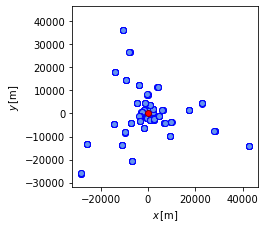

In [3]:
from farm.observing import Telescope
from farm.miscellaneous.plotting import plot_ants

telescope_model = Path(farm_init_path).parent / 'data' / 'files' / 'telescope.tm'
telescope = Telescope(telescope_model)

print(telescope.summary())
fig, ax = plot_ants(telescope, savefig=False)
fig.set_dpi(300)

### Correlator class
To handle the observed list of frequencies, the `farm.observing.Correlator` class has be created. In short, this is composed of instance(s) of the `farm.observing.Subband` class, each of which handles the frequency information for a single observing band e.g. C-band. In order to instantiate and instance of the Correlator class, one mandatory, and one optional argument are given to its constructor:
- `t_int` (`float`): Visibility integration time \[s\]
- `subbands`, optional (`List[Subband]`): List of `Subband` instances containing each sub-band's frequency information

#### Properties
The `Correlator` class contains the following properties:
- `frequencies` (`List[numpy.array]`): List of 1D numpy arrays of frequencies from all sub-bands
- `n_subbands` (`int`):
- `subbands` (`List[Subband]`): List of subbands composing the `Correlator`. Add new `Subband` instances only using the `add_subband` method.
- `t_int` (`float`): Visibility integration time \[s\]

#### Methods
Only one method is attributed to the `Correlator` class:
- `add_subband` (`List[Subband] | Subband`): Add `Subband`(s) to the `Correlator`

### Subband class
Designed to handle the frequency information for a single observing sub-band e.g. C-band, this forms the composition of the `Correlator` class, and one instance of a `Subband` is at least required for a `Correlator` to make an observation in conjunction with a `Telescope`.

In order to instantiate a `Subband` instance, the following arguments are required:
1. `freq0` (`float`): Minimum frequency of lowest channel's coverage \[Hz\]
2. `chan_width` (`float`): Channel width \[Hz\]
3. `nchan` (`int`): Number of channel in `Subband`
4. `name`, optional (`str`): Name to attribute to `Subband`. If not given, this will be automatically generated.

In [4]:
from farm.observing import Correlator, Subband

h21cm = Subband(freq0=144e6, chan_width=1e6, nchan=11, name='H21cm')
correlator = Correlator(t_int=10.)
correlator.add_subband(h21cm)

print(f"Subband instance:\n{h21cm}", f"Correlator instance:\n{correlator}",
      sep='\n\n')

Subband instance:
Band H21cm: 11 × 1.00MHz channels from 144.0 - 155.0MHz

Correlator instance:
Correlator (t_int=10.0s) with 1 subband(s):
 - Band H21cm: 11 × 1.00MHz channels from 144.0 - 155.0MHz


## Specifying observational Scans
To contain information and methods associated with each observational scan of the target field, instances of the `farm.observing.Scan` are required (one per scan). In order to instantiate a `Scan`, only two arguments are required:
- `start` (`astropy.Time`): Scan start time
- `end` (`astropy.Time`): Scan end time

### Properties
The `Scan` class contains the following properties:
- `start` (`astropy.Time`): Scan start time
- `end` (`astropy.Time`): Scan end time
- `duration` (`float`): Duration of the scan in seconds

### Methods
Only one method is defined:
- `n_int` (`t_int`: `float`) -> `int`: Number of visibility integration times across the whole scan. Takes one argument, `t_int`, which is othe visibility integration time in seconds.

The example below defines a scan starting at 5:30pm on 2nd May 2023, lasting for 10 minutes and 30 seconds:

In [5]:
from astropy.time import Time
from astropy import units as u
from farm.observing import Scan

duration = 10. * u.minute + 30 * u.second
t_start = Time("2023-05-02T17:30:00")
t_end = t_start + duration
scan = Scan(t_start, t_end)

print(scan)

Scan from 17:30:00-02MAY2023 to 17:40:30-02MAY2023 (t_scan = 630s)


### Generating a full set of Scans
A convenience method, `farm.observing.generate_scans`, has been created as an easy way of creating the relevant `Scan`s, given that geographical location, celestial coordinates, as well as other factors affecting the observational times. `generate_scans` takes the following arguments:
- `t_start` (`astropy.Time`): Desired start time of the first scan
- `coord0` (`astropy.coordinates.SkyCoord`): Celestial coordinate of the pointing centre of observation
- `location (`astropy.EarthLocation`): Location of the telescope
- `n_scan` (`int`): Number of scans desired
- `t_total` (`float`): Total time on target \[s\]
- `min_elevation` (`float`): Minimum elevation of target \[deg\]. Default is `20.0`
- `min_gap_scan` (`float`): Minimum gap between scans of the target \[s\]. Default is `120.0`
- `partial_scans_allowed` (`bool`): Whether scans can be broken across minimum elevation boundaries. Default is `False`

In the example below, we use the previously defined `Telescope` instance's location, and `Field` instance's pointing centre to create 5 `Scan` instances. These instances cover a total of 1 hour of on-source time, at a minimum elevation of 30 degrees, and minimum gap between consecutive scans of 30 minutes (simulating calibrator-source scans, or other-target scans). Notice how the first `Scan`'s start time is not the same as the provided `t_start` since the target is below the minimum elevation at that time. A plot shows the scan times as cyan lines (start is a green marker, end is a red marker) overlaid on the target's elevation/azimuth plot.

Scan 01: Scan from 22:37:17-02MAY2023 to 22:49:17-02MAY2023 (t_scan = 720s)
Scan 02: Scan from 23:19:17-02MAY2023 to 23:31:17-02MAY2023 (t_scan = 720s)
Scan 03: Scan from 00:01:17-03MAY2023 to 00:13:17-03MAY2023 (t_scan = 720s)
Scan 04: Scan from 00:43:17-03MAY2023 to 00:55:17-03MAY2023 (t_scan = 720s)
Scan 05: Scan from 01:25:17-03MAY2023 to 01:37:17-03MAY2023 (t_scan = 720s)


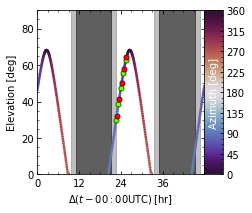

In [6]:
from farm.observing import generate_scans
from farm.miscellaneous.plotting import target_altaz

n_scans, t_total, min_el, t_gap = 5, 1 * 60 * 60, 30., 30 * 60.
scans = generate_scans(t_start, field.coord0, telescope.location, n_scans,
                       t_total, min_el, t_gap, partial_scans_allowed=False)

print(*[f"Scan {i + 1:02}: {scan}" for i, scan in enumerate(scans)], sep='\n')
target_altaz(scans[0].start, telescope.location, field.coord0,
             scan_times=[(s.start, s.end) for s in scans]);

## Direction-independent calibration errors
In order to introduce direction-independent calibration errors, the `farm.calibration.CalibrationErrors` class has been created which is composed of single `farm.calibration.BandpassErrors` and `farm.calibration.GainsErrors` instances for the frequency and time-dependent errors, respectively. As a word of warning, the bandpass and gains errors' data-array shapes must match the that of the `Subband` and `Scan` to which they will ultimately be attached.

### BandpassErrors
Designed to simulate the frequency-dependent calibration errors (i.e. bandpass errors), the following arguments are taken by `BandpassErrors` constructor method:
- `n_freq` (`int`): Number of frequency channels
- `n_stations` (`int`): Number of telescope stations/dishes
- `beta` (`float`): Exponent of generated noise whereby $S(f) = f^{-\beta}$. Defaults to 2 (brown noise)
- `mean_amp` (`float`): Mean amplitude of errors. Defaults to 1
- `mean_phase` (`float`): Mean phase of errors \[deg\]. Defaults to 0
- `std_amp` (`float`): Standard deviation of error amplitudes. Defaults to 0.1
- `std_phase` (`float`): Standard deviation of error phases \[deg\]. Defaults to 0.1
- `rseed` (`int`): Random number generator seed. Defaults to 12345

#### Properties
`BandpassErrors` has the following properties in addition to those declared during its instantiation:
- `errors` (`np.array`): Table of the complex calibration errors of shape `(n_stations, n_freq)`
- `mean_phase_rads` (`float`): Mean phase of errors in radians
- `std_phase_rads` (`float`): Standard deviation of the phase errors in radians

### GainsErrors
Designed to simulate the time-dependent calibration errors (i.e. gains errors), the same arguments are taken by `GainsErrors` constructor method as `BandpassErrors` (see above), with one exception. Instead of `n_freq`, instead `n_times` is required in its place.

#### Properties
As well as the arguments required for instantiation, all properties of `BandpassErrors` are present. However, `errors` has a shape of `(n_stations, n_times)`.

### CalibrationErrors
Thus, to fold the two types of errors into the same object, the `CalibrationErrors` class is used. For instantiation, `gains_errs` and `bpass_errs` form the only two arguments, which are required and take a `GainsErrors`, and `BandpassErrors` instance, respectively.

#### Properties
As well as the arguments used in the construction of a `CalibrationErrors` instance (`gains_errs`, `bpass_errs`), an instance also holds the following attributes/properties:
- `n_times` (`int`): Number of gain errors in time
- `n_freq` (`int`): Number of frequency channels
- `n_stations` (`int`): Number of telescope stations/dishes
- `errors` (`np.array`): Table of the complex calibration errors of shape `(n_times, n_freq, n_stations)`

### Example
The example below uses our previously calculated `Scan`s, as well as `Correlator` in order to ensure accurate data-array shapes for the errors with respect to the specified observation. Resulting calibration errors are stored in a `dict` until they are ready to be added to the `Observation` instance set up (see below):

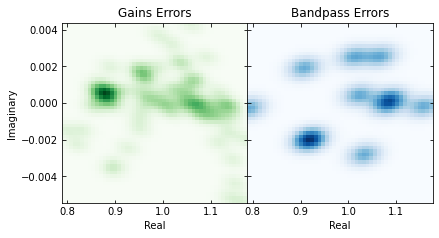

In [7]:
from farm.calibration import BandpassErrors, CalibrationErrors, GainsErrors
from farm.miscellaneous.plotting import plot_calibration

calibration_errs = {}
for scan in scans:
    calibration_errs[scan] = {}
    n_int = scan.n_int(correlator.t_int)
    for subband in correlator.subbands:
        gains_errs = GainsErrors(n_int, telescope.n_stations)
        bpass_errs = BandpassErrors(subband.nchan, telescope.n_stations, rseed=gains_errs.rseed + 1)
        cal_errs = CalibrationErrors(gains_errs, bpass_errs)
        calibration_errs[scan][subband] = cal_errs

# 2D-density plot of real/imaginary components of calibration errors for the
# last scan/subband across all stations/frequencies/times
fig, (ax1, ax2) = plot_calibration(cal_errs)

## Direction-dependent calibration errors
Direction-dependent errors are caused by variations in the total electron count (TEC) across the atmosphere. These variations are quantified via the differential TEC (dTEC) between the reference antenna/station's TEC and the other antennae/stations. Direction-dependent calibration errors must be considered, especially at low (~MHz) frequencies where their effects are significant.

### TECScreen Class
Our `TECScreen` class simulates the total electron content in the ionosphere by utilising the `ARatmospy` [package](https://github.com/shrieks/ARatmospy). Specifically, the `TECScreen` class uses our own version of the `ARatmospy.ArScreens.ArScreens` class. In our version (`farm.calibration.tec._ArScreens`), the information used in the instantiation of an `_ArScreens` instance is preserved in instance properties, including the random number generation seed (`_ArScreens.rseed`). This allows for more precise book-keeping further down the line. As a note, only the `TECScreen` class should be used in a pipeline (i.e. not `_ArScreens

In order to instantiate a `TECScreen` instance, the following, mandatory arguments are used:
- `t_start` (`astropy.time.Time`): Start time of the TEC screen
- `t_end` (`astropy.time.Time`): End time of the TEC screen
- `t_int` (`float`): Time between consecutive frames in the screen \[s\]
- `pixel_m` (`float`): Pixel size \[m\]
- `fov` (`float`): Field of view \[deg\]
- `bmax` (`float`): Maximum baseline length \[m\]
- `layer_params` (`Path | list[dict]`): Either a dictionary with each layer's parameters, or a path to a data file containing the same (see below example). Parameters for each layer are $r_0$ (phase coherence length), velocity, direction and altitude.
- `alpha_mag` (`float`): Magnitude of autoregressive parameter. (1-alpha_mag) is the fraction of the phase from the prior time step that is "forgotten" and replaced by Gaussian noise
- `rseed` (`int`): Random number generation seed.

**NB** - Be aware that, as it stands, a `TECScreen` must cover the entire time-range between the first and last `Scan` in your observation (including gaps between). This is because `ARatmospy` works by evolving a phase screen between successive frames in time. Creating a new `TECScreen` for each `Scan` loses the state of the phase screen from the previous scan, and in this case therefore the `TECScreen` would show discontinuities between successive `Scan`s. A solution to this should be something that is developed in the future to avoid exceeding available memory for long observations, as well as unnecessarily increasing computational time.

#### Properties
Properties/attributes of `TECScreen` instances include:
- `t_start` (`astropy.time.Time`): Start time of the TEC screen
- `t_end` (`astropy.time.Time`): End time of the TEC screen
- `interval` (`float`): Time between consecutive frames in the screen (i.e. `t_int`) \[s\]
- `arscreen` (`_ArScreens`): Instantiate `farm.calibration.tec._ArScreens` instance
- `cube` (`Path`): Full path to which the .fits cube was written
- `duration` (`float`): Total extent in time of the phase screen \[s\]
- `rate` (`float`): 1 / duration \[Hz\]
- `rseed` (`int`): Random number generator seed
- `times` (`tuple[Time]`): Tuple of times of each frame of `TECScreen`

As a note, some properties used to instantiate the `TECScreen` class not listed above can be accessed as properties of the `arscreen` attribute above i.e. `arscreen.alpha_mag` and `arscreen.layer_params`.

#### Methods
Methods of the `TECScreen` class include:
- `create_from_fits(fitsfile: Path)`: Load a .fits file as a TECScreen
- `create_tec_screen(fitsfile: Path)`: Run the phase screen generation and write results to a fits file. This .fits file path is then assigned to the `TECScreen.cube` attribute and used to load the TECScreen data array. Can only be run once, otherwise will remind the user that `TECScreen` was already written to file.
- `extract_tec_screen_slice(slice_fitsfile: Path, t_start: Time, t_end: Time)`: Extract the TEC screen between `t_start` and `t_end` and write to fits file. Be aware that this requires the `TECScreen` to have been written to file previously (using the `create_tec_screen` method.

An example of `TECScreen` instantiation/generation is below with a dTEC plot of all stations and summary of the `TECScreen` instance:

TECScreen of 2208 × 2208 pixels (100m pixel size) covering 220.8 km² (39.2deg² at centre) and comprised of 2 layers whose properties are: 

 - Layer 00 -> r0: 1.0e+04m; vel: 40.0m/s; direction: 60.0deg; altitude: 3.0e+05m
 - Layer 01 -> r0: 1.0e+04m; vel: 23.5m/s; direction: 32.0deg; altitude: 3.1e+05m

dTECs written to /Users/simon.purser/pylib/farm/data/files/TECScreen.fits.


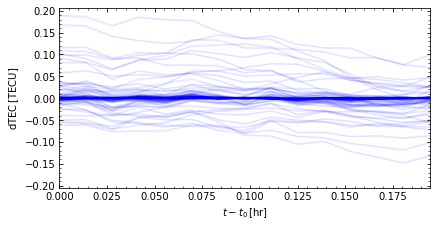

In [8]:
from farm.calibration import TECScreen
from farm.miscellaneous.plotting import plot_dtec

t_start = scans[0].start
t_end = scans[0].end
pixel_m = 100.  # Should be roughly equal to minimum baseline length
alpha_mag = 0.999  # Default value
layer_params = Path('../data/files/tec_layers.data')
# OR
# layer_params = [{'r0': 1e4, 'vel': 40.0, 'direction': 60.0, 'altitude': 300e3},
#                 {'r0': 1e4, 'vel': 23.5, 'direction': 32.0, 'altitude': 310e3}]

tec = TECScreen(
    t_start, t_end, correlator.t_int * 5, pixel_m=pixel_m, fov=max(field.fov),
    bmax=max(telescope.baseline_lengths.values()), layer_params=layer_params,
    alpha_mag=alpha_mag, rseed=123456789
)

tec.create_tec_screen(Path('../data/files/TECScreen.fits'))

print(tec.summary)
plot_dtec(telescope, tec.cube);

## Creating our SkyModel
In order to handle the sky model (i.e. flux on the sky as a function of direction and frequency), both the `SkyModel` and `SubbandSkyModel` classes have been created. In essence, a `SkyModel` instance is comprised of individual `SubbandSkyModel` instances (one per `Subband` of our `Correlator`), themselves comprised of `SkyComponent` instances.

### SkyComponent class
A single `SkyComponent` instance represents any abstract source or group of sources on the night sky e.g. compact sources, extended Galactic emission etc. For a full representation, one `SkyComponent` instance is required per `Subband` due to the possibility of non-contiguous frequency coverage across several `Subband` instances making up a `Correlator` setup.

#### Different constructor methods
There are multiple ways to instantiate/create a `SkyComponent` instance, aside from the normal (i.e. . Starting with the default constructor method:

##### `SkyComponent.__init__`
Requires the following args:
- `name`: `str` - Name to give the `SkyComponent`
- `npix`: `Tuple[int, int]` - Number of pixels in RA and dec
- `cdelt`: `float` - Pixel/cell size [deg]
- `coord0`: `SkyCoord` - Central coordinate
- `tb_func`: `farm.sky_model.tb_functions.TbFunction` - A callable (function) which must take two args: `sky_component` (`SkyComponent` instance); and `freq` (`float|np.array`) and returns a `np.array` of brightness temperatures \[K\] for that `SkyComponent` at the provided frequency(s).

**NB** - Here, `tb_func` allows you to customise any flux distribution on the sky and thus create a custom `SkyComponent` for any use case (see below section, 'Creating a custom `SkyComponent`')

##### `load_from_dataframe`
Creates a `SkyComponent` from a `pandas.DataFrame` instance. Arguments are:
- `df`: `pandas.DataFrame` - Pandas `DataFrame` containing full source catalogue
- `name`: `str` - Name to give the `SkyComponent`
- `cdelt`: `float` - Pixel/cell size [deg]
- `coord0`: `SkyCoord` - Central coordinate
- `fov`: `Tuple[float, float]` - Field of view in RA and declination \[deg\]
- `freqs`: `Union[Subband, np.array]` - Frequencies to add to the SkyComponent \[Hz\]
- `flux_range`: `Tuple[float, float]` -  Flux range within which to include sources \[Jy\]
- `beam`: `Dict[str, Union[float, int]]` 0 Beam with which to deconvolve dimensions as a dict i.e. `{'maj': 120, 'min': 120., 'pa': 0.}` \[deg\]

Column requirements in the `pandas.DataFrame`, `df`, are:
- `fluxI`: Stokes-I flux \[Jy\]
- `ra`: Right ascension \[deg\]
- `dec`: Declination \[deg\]
- `freq0`: Reference frequency for flux \[Hz\]
- `spix`: Spectral index
- `maj`: Source major axis FWHM \[arcsec\]
- `min`: Source minor axis FWHM \[arcsec\]
- `pa`: Source major axis position angle (east from north) \[deg\]


##### `load_from_fits`
Creates a `SkyComponent` from a `.fits` image. Arguments are:
- `fitsfile`: `pathlib.Path` - Full path to the `.fits` image
- `name`: `str` - Name to give the `SkyComponent`
- `cdelt`: `float` - Pixel/cell size [deg]
- `coord0`: `SkyCoord` - Central coordinate
- `freqs`: `Union[Subband, np.array]` - Frequencies to add to the SkyComponent \[Hz\]

An example of using this method is show below whereby an `.fits` image representing an artifical model of Galactic diffuse emission is used to create a `SkyComponent` instance:

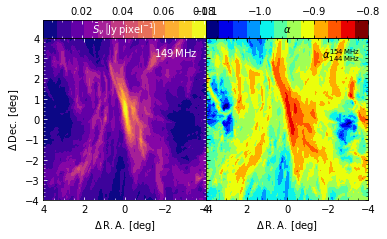

In [9]:
from farm.miscellaneous.plotting import plot_flux_and_spix
from farm.sky_model import SkyComponent

# Set up a sky component from a .fits image of Galactic diffuse emission
fitsfile_galactic = Path('../data/files/Gsynch_SKAs.fits')
galactic = SkyComponent.load_from_fits(
    fitsfile=fitsfile_galactic, name='Galactic',
    cdelt=field.cdelt, coord0=field.coord0,
    freqs=correlator.subbands[0]
)

plot_flux_and_spix(galactic);


##### `load_from_fits_table`
Creates a `SkyComponent` from a `.fits` file containing tabular data. Arguments are the same as for `load_from_dataframe`, except for `df` which is replace by `fitsfile` (`pathlib.Path`), which is the full path to the `.fits` table. Column requirements are identical to `load_from_dataframe`.

##### `load_from_oskar_sky_model`
Creates a `SkyComponent` from an Oskar sky model file. Arguments are the same as for `load_from_dataframe`, except for `df` which is replace by `osmfile` (`pathlib.Path`), whichi is the full path to the oskar sky model file. See the OSKAR documentation [here](https://ska-telescope.gitlab.io/sim/oskar/sky_model/sky_model.html) for the exact catalogue format required.

SkyComponent instance, 'LoBES', in table format consisting of (49 Gaussians and 960 point-like sources (1009 total) written to /Users/simon.purser/pylib/farm/notebooks/LoBES.osm


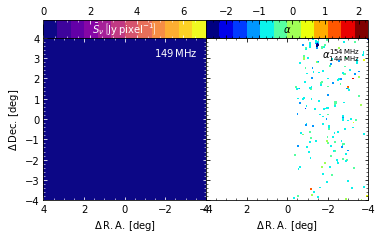

In [10]:
from astropy.coordinates import SkyCoord
import numpy as np
# Set up a sky component from a oskar sky model of the LoBES survey
osm_lobes = Path('../data/files/GLM_LoBESv2.osm')
lobes = SkyComponent.load_from_oskar_sky_model(
    osmfile=osm_lobes, name='LoBES',
    cdelt=field.cdelt, coord0=field.coord0,
    fov=field.fov, freqs=correlator.subbands[0],
    flux_range=(0., 1e30)
)
lobes.summary()
plot_flux_and_spix(lobes);


#### Parameters
- `cdelt` (`float`): Pixel size \[deg\]
- `coord0` (`astropy.coordinates.SkyCoord`): Central coordinate
- `frequencies` (`np.array`): List of all computed frequencies for this `SkyComponent`
- `header` (`astropy.io.fits.Header`): `fits.Header` for 3D (spectral) cube
- `header2d` (`astropy.io.fits.Header`): `fits.Header` for 2D (no spectral information) cube

#### Methods
- `add_frequency`(`new_freq`: `List[float]|float`): Add frequency, `new_freq`, (also internally computes $T_{\rm b}$) to `SkyComponent`
- `data`(`unit`: `str`) -> `np.array`: 3D `numpy.array` of all brightness data at all added frequencies in units, `unit` (can be `'K'`, `'JY/PIXEL'`, or `'JY/SR'`
- `flux_nu`(`freq`: `float`) -> `np.array`: Compute flux at given `freq`
- `frequency_present`(`freq`: `float`) -> `bool`: Is the given `freq` added to this `SkyComponent`?
- `i_nu`(`freq`: `float`) -> `np.array`: Compute intensity at given `freq`


#### Creating a custom SkyComponent
As described above, the basic constructor method (`__init__`) for the `SkyComponent` class takes multiple arguments. One of those arguments is `tb_func` whose `type` is `Callable` (i.e. a function) taking two arguments: a `SkyComponent` instance; and a frequency (or array of frequencies), returning a `numpy.array` of brightness temperatures (in K). Thus, you can create a custom `SkyComponent` class.

As an example, we will create a SkyComponent describing a spherical, HII region of uniform density. To do this, we create our custom `tb_func` to be used to instantiate our custom `SkyComponent`. In this particular case, we have 'wrapped' the actual function in another function so that we may create multiple `tb_func`s describing multiple HII regions with different physical properties. However, for this example we will create an HII region with:

- Electron density of 1000 $\mathrm{e^-\,m}^{-3}$
- Diameter of 30 arcmin
- Distance of 1kpc
- Electron temperature of 10000K
- Offset from the field centre by +0.5 deg in both RA and dec:

SkyComponent instance, 'HII_A', in image format, over 11 channels from 144.0-154.0MHz on an image grid of 500×500, 30.0 arcsec pixels


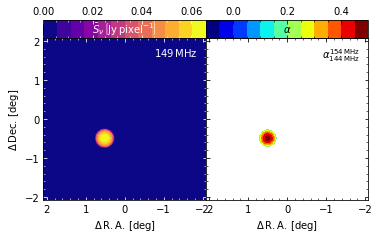

In [11]:
from typing import Callable
from astropy.coordinates import SkyCoord


def hii_region(coord: SkyCoord, radius_deg: float,
               dist_pc: float, electron_density: float,
               electron_temp: float = 1e4) -> Callable:
    """
    Wrapper function which returns the function below embedded with all the
    parameters to describe an individual HII region with those parameters
    """
    from typing import Union
    import numpy.typing as npt

    def tb_func(sky_component: SkyComponent,
                freq: Union[float, npt.NDArray]) -> npt.NDArray:
        """
        Wrapped inner function which will ultimately be the Callable passed to
        SkyComponent's constructor and thus only takes two args, a SkyComponent
        instance, and frequency(s) at which it will return a numpy array of
        brightness temperatures [K]
        """
        import warnings
        import numpy as np
        import scipy.constants as con

        radius_m = dist_pc * con.parsec * np.tan(np.radians(radius_deg))

        n_freq = 1 if isinstance(freq, float) else len(freq)
        hdr = sky_component.header2d
        yy_pix, xx_pix = np.meshgrid(np.arange(1, hdr['NAXIS2'] + 1),
                                     np.arange(1, hdr['NAXIS1'] + 1),
                                     indexing='ij')

        # Offsets from centre [deg]
        centre_ra_offset = sky_component.coord0.ra.deg - coord.ra.deg
        centre_dec_offset = coord.dec.deg - sky_component.coord0.dec.deg
        dxx_deg = (xx_pix - hdr['CRPIX1']) * hdr['CDELT1'] + centre_ra_offset
        dyy_deg = (yy_pix - hdr['CRPIX2']) * hdr['CDELT2'] + centre_dec_offset

        # Offsets from centre of HII region, at the HII region's distance [m]
        dxx_m = dist_pc * con.parsec * np.tan(np.radians(dxx_deg))
        dyy_m = dist_pc * con.parsec * np.tan(np.radians(dyy_deg))

        # Path length of grid's pixels' lines-of-sight within the HII region.
        # Warnings suppressed as np.sqrt raises RuntimeWarning for -ve args
        with warnings.catch_warnings():
            warnings.filterwarnings(action='ignore', category=RuntimeWarning)
            path_lengths = np.where(
                (dxx_m ** 2 + dyy_m ** 2) < radius_m ** 2.,
                2. * np.sqrt(radius_m ** 2 - dxx_m ** 2 - dyy_m ** 2), 0.
            )

        # Calculate optical depths and brightness temperatures at each frequency
        tbs = np.zeros(shape=(n_freq, ) + xx_pix.shape)
        for idx, f in enumerate([freq] if isinstance(freq, float) else freq):
            optical_depths = (8.235e-2 * electron_temp ** -1.35 * f ** -2.1 *
                              electron_density ** 2. * path_lengths)
            tbs[idx] = electron_temp * (1. - np.exp(-optical_depths))

        return tbs
    return tb_func


hii_region_tb_func = hii_region(
    coord=field.coord0.spherical_offsets_by(0.5 * u.deg, 0.5 * u.deg),
    radius_deg=15 / 60., dist_pc=1e3, electron_density=1000,
    electron_temp=1e4
)

hii_region_sky_component = SkyComponent(
    name='HII_A', npix=(500, 500), cdelt=30 / 3600.,
    coord0=field.coord0, tb_func=hii_region_tb_func
)

hii_region_sky_component.add_frequency(correlator.subbands[0])
hii_region_sky_component.summary()
plot_flux_and_spix(hii_region_sky_component);

### SubbandSkyModel class
The `SubbandSkyModel` class is designed to handle the sky model for a single, contiguous range in frequency i.e. a single `Subband`. The reason for this design choice is that when writing the resultant `.fits` images forming input to Oskar, `.fits` headers can only deal with contiguous ranges in frequency. Thus, to cover the full range in frequencies across all `Subband`s instances may take much more memory than necessary considering the actual desired frequencies of observation in the `Correlator`.

Instantiating a `SubbandSkyModel` requires the following arguments:
- `n_pix` (`Tuple[int, int]`): Number of pixels in $x$ and $y$ as a 2-`tuple`
- `cdelt` (`float`): Pixel/cell size \[deg\]
- `coord0` (`astropy.coordinates.SkyCoord`): Central coordinate of the sky model
- `frequencies` (`numpy.array|Subband`): Frequencies of the sky model as an array of floats, or a `Subband` instance

**TODO**: As mentioned, the caveat of adding different SkyComponent instances together under a SkyModel, is that all fluxes are additive i.e. optical depths are assumed to be thin ($\tau \to 0$). Thus, in order to extend the realism of the additive `SkyModel`, in addition to a `tb_func`, an `optical_depth_func` would have to be provided (and implemented within the class) to the `SkyComponent` constructor. This would allow realistic computation of fluxes where optical depth would be an issue.

### SkyModel class


/Users/simon.purser/pylib/farm/miscellaneous/error_handling.py:35: UserWarning: /Users/simon.purser/Desktop/test_sb_sky_model.fits already exists. Overwriting
  warnings.warn(warning_message, warning_type)


SubbandSkyModel instance, comprised of 3 components (1 tabular fmt, 2 image fmt) for the H21cm subband.
Tabular sources -> 49 Gaussians, 960 point-like sources (1009 total) written to /Users/simon.purser/pylib/farm/notebooks/SubbandSkyModel_SubbandH21cm.osm
Image grid -> 512×512, 56.2 arcsec pixels


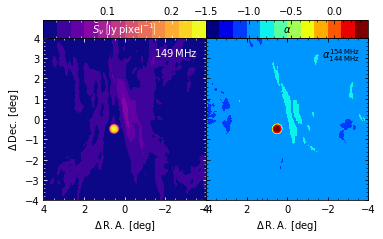

In [14]:
from farm.miscellaneous.plotting import plot_flux_and_spix
from farm.sky_model import SkyModel, SubbandSkyModel

# Set up over-arching SkyModel instance
sky_model = SkyModel(
    n_pix=(field.nx, field.ny), cdelt=field.cdelt, coord0=field.coord0,
    subbands=correlator.subbands
)

# SkyModel for first, individual Subband
sb_sky_model = SubbandSkyModel(
    n_pix=(field.nx, field.ny), cdelt=field.cdelt, coord0=field.coord0,
    subband=correlator.subbands[0]
)

# Ensure that the SkyComponent is on the same grid as the SubbandSkyModel
# and add to SubbandSkyModel
sb_sky_model.add_component(galactic.regrid(sb_sky_model))
sb_sky_model.add_component(lobes)
sb_sky_model.add_component(hii_region_sky_component.regrid(sb_sky_model))

# Add Subband's SkyModel to overarching SkyModel
sky_model.add_subband_skymodel(correlator.subbands[0], sb_sky_model)
sb_sky_model.write_fits(Path('/Users/simon.purser/Desktop/test_sb_sky_model.fits'), unit='JY/PIXEL')
sb_sky_model.summary()
fig, _ = plot_flux_and_spix(sb_sky_model);

Notice how point sources are left out of the figure above. This is because their representative `SkyComponent`, `lobes`, was created from a table (oskar sky model format). This information is preserved so that upon feeding the sky model into Oskar, the source are added in tabular format, rather than image format. Thus, when writing the `.fits` image, the point sources are not present, only those components added from a `.fits` image.

## Running an observation
Executing an observation utilises Oskar, with measurement sets constituting the data products. In order to do this, we use the set up from above which, as a recap, includes the following variables (with their types annotated after the colons):
- `field: Field` - Holds details of the observational field
- `telescope: Telescope` - Contains full information about the telescope to be used for the observation
- `correlator: Correlator` - Contains all of our frequency setup and supporting information
- `tec: TECScreen` - Contains TEC information and thus direction-dependent errors
- `calibration_errs: Dict[Scan, Dict[Subband, CalibrationErrors]]` - All direction-independent calibration errors as a `dict` whose key/value pairs are `Scan` instances and other `dict`s, whose subsequent key/value pairs are `Subband` instances and `CalibrationErrors` corresponding to that `Scan` and `Subband`
- `sky_model: SkyModel` - Our full sky model  constituted of individual SubbandSkyModel instances for each Subband, themselves constituted of individual `SkyComponent` instances

To tie these together under one coherent class, the `farm.observing.Observation` class has been created:

In [13]:
from farm.observing import Observation

# 1. Create Observation instance from a defined Field, Telescope and Correlator
observation = Observation(field, telescope, correlator)

# 2. Add in all required scans to Observation
observation.add_scan(scans)

# 3. Add in all relevant direction-independent calibration errors for each scan
#    and subband
for scan in calibration_errs.keys():
    for subband, cal_errs in calibration_errs[scan].items():
        observation.add_cal_errs(cal_errs, scan, subband)

# 4. Add in TECScreen i.e. direction-dependent calibration errors
observation.add_tecscreen(tec)

print(observation)

Observation of 1h02m03.4s, -5d06m07.89s, totalling 1.00 hours split over 5 scan(s):
 - Scan from 22:37:17-02MAY2023 to 22:49:17-02MAY2023 (t_scan = 720s)
 - Scan from 23:19:17-02MAY2023 to 23:31:17-02MAY2023 (t_scan = 720s)
 - Scan from 00:01:17-03MAY2023 to 00:13:17-03MAY2023 (t_scan = 720s)
 - Scan from 00:43:17-03MAY2023 to 00:55:17-03MAY2023 (t_scan = 720s)
 - Scan from 01:25:17-03MAY2023 to 01:37:17-03MAY2023 (t_scan = 720s)
